# Sign Language Recognition - Modelo de reconhecimento de padrões dos movimentos: 

### - 1D CNN baseado na arquitetura de redes residuais: ResNet

O objetivo desta atividade é tentar realizar a classificação de palavras, em forma de movimentos/sinais, da linguagem de sinais. Mesmo sendo um tópico que tem sido estudado e trabalhado há algum tempo, ainda hoje não se tem por exemplo um aplicativo para ensinar linguagem de sinais do tipo: *Learn by doing* como a exmeplo o Duolingo. Tendo em vista essa questão, a ideia é criar um modelo que seja capaz de através da captura de video possa realizar o sequenciamento dos frames com a marcação dos landmarks das mãos, braços e rosto, e ter esses dados em forma de série temporal.

Com isso, a ideia é aplicar os dados a uma rede convolucional unidimensional, cuja arquitetura se baseia em blocos residuais a fim de evitar o *vanishing gradient*. O modelo em questão nasceu do artigo: *Deep Residual Learning for Image Recognition* vencedor da competição *ImageNet* de 2015.

Abaixo temos o passo a passo de todo o pipeline necessário para começar a testar os possíveis modelos.

### Imports Necessários

In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib as mpl

import keras
from keras import layers, models
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from keras.layers import Masking, Reshape
from tensorflow.keras.optimizers.schedules import ExponentialDecay

import sys
import os
import cv2
import json
import mediapipe as mp

### Configurações globais de Plot

In [2]:
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 24


## Data Analysis

### Extraindo os dados do arquivo JSON que contem informaçoes sobre os videos

In [6]:
with open('dataset/WLASL_v0.3.json', 'r') as json_file:
    all_data = json.load(json_file)
all_data[1]

{'gloss': 'drink',
 'instances': [{'bbox': [551, 68, 1350, 1080],
   'fps': 25,
   'frame_end': -1,
   'frame_start': 1,
   'instance_id': 0,
   'signer_id': 115,
   'source': 'aslbrick',
   'split': 'val',
   'url': 'http://aslbricks.org/New/ASL-Videos/drink.mp4',
   'variation_id': 0,
   'video_id': '69302'},
  {'bbox': [153, 11, 488, 370],
   'fps': 25,
   'frame_end': -1,
   'frame_start': 1,
   'instance_id': 1,
   'signer_id': 94,
   'source': 'aslsignbank',
   'split': 'train',
   'url': 'https://aslsignbank.haskins.yale.edu/dictionary/protected_media/glossvideo/ASL/DR/DRINK-119.mp4',
   'variation_id': 0,
   'video_id': '65539'},
  {'bbox': [142, 20, 501, 480],
   'fps': 25,
   'frame_end': 5831,
   'frame_start': 5710,
   'instance_id': 2,
   'signer_id': 121,
   'source': 'northtexas',
   'split': 'val',
   'url': 'https://www.youtube.com/watch?v=F5Wef1_PtLk',
   'variation_id': 0,
   'video_id': '70173'},
  {'bbox': [112, 13, 529, 356],
   'fps': 25,
   'frame_end': 71,
   '

### Extraindo informações relevantes do JSON

O código abaixo cria uma lista chamada 'data' que armazena as principais features de cada video através da estrutura do JSON.

In [9]:
video_dir = 'dataset/videos'
data = []

for i in tqdm(range(len(all_data)), ncols=100):
    gloss = all_data[i]['gloss']
    instances = all_data[i]['instances']
    for instance in instances:
        video_id = instance['video_id']
        if os.path.exists(os.path.join(video_dir, f'{video_id}.mp4')):
            video_path = os.path.join(video_dir, f'{video_id}.mp4')
        else:
            continue

        frame_start = instance['frame_start']
        frame_end = instance['frame_end']
        split = instance['split']
        data.append({
            'gloss': gloss,
            'video_path': video_path,
            'frame_start': frame_start,
            'frame_end': frame_end,
            'split': split
        })


  0%|                                                                      | 0/2000 [00:00<?, ?it/s]

In [10]:
df = pd.DataFrame(data)
df.head(20)


,gloss,video_path,frame_start,frame_end,split
0,book,dataset/videos/69241.mp4,1,-1,train
1,book,dataset/videos/07069.mp4,1,-1,train
2,book,dataset/videos/07068.mp4,1,-1,train
3,book,dataset/videos/07070.mp4,1,-1,train
4,book,dataset/videos/07099.mp4,1,-1,val
5,book,dataset/videos/07074.mp4,1,-1,train
6,drink,dataset/videos/69302.mp4,1,-1,val
7,drink,dataset/videos/65539.mp4,1,-1,train
8,drink,dataset/videos/17710.mp4,1,-1,train
9,drink,dataset/videos/17733.mp4,1,-1,train


Analisando quais as palavras com maior número de videos

<AxesSubplot:title={'center':'Top 50 Signs'}>

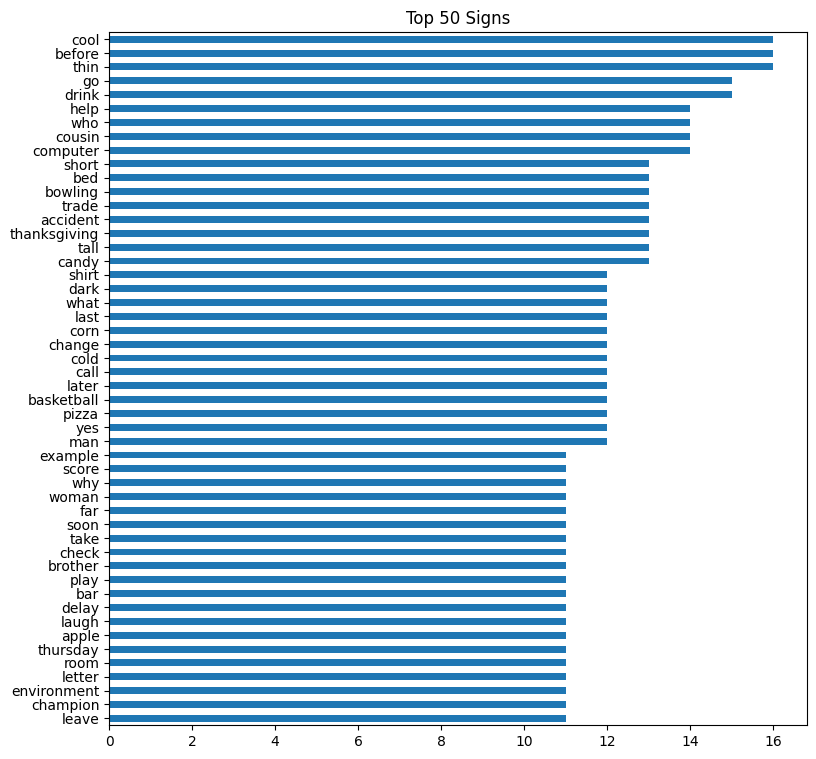

In [5]:
df['gloss'].value_counts().head(50).sort_values(ascending=True).plot(kind='barh',figsize=(9,9),title='Top 50 Signs')


Mesma análise anterior porém para as palavras menos frequentes.

<AxesSubplot:title={'center':'Bottom 50 Signs'}>

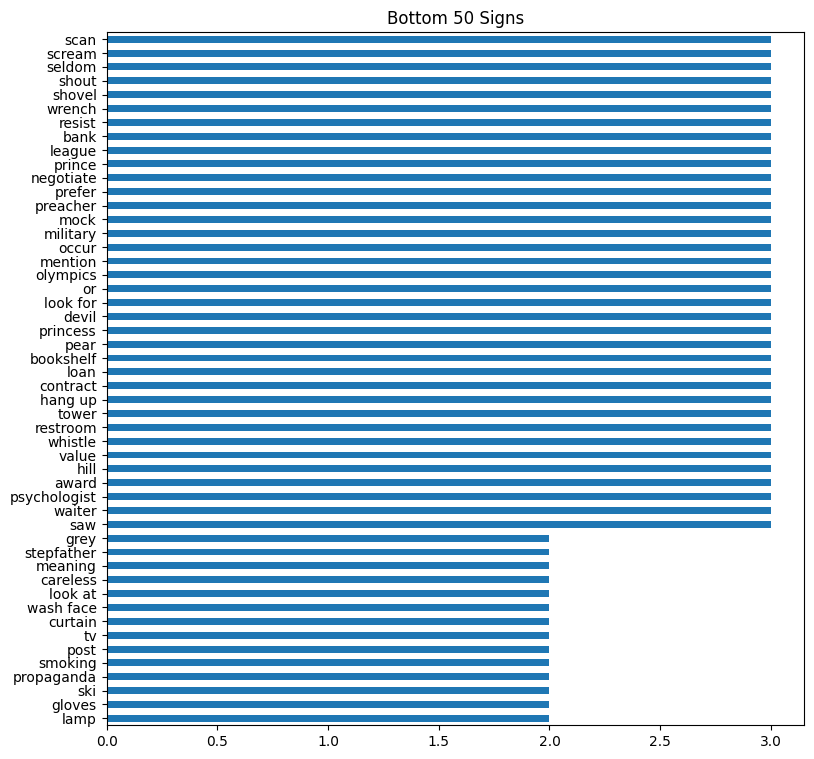

In [6]:
df['gloss'].value_counts().tail(50).sort_values(ascending=True).plot(kind='barh',figsize=(9,9),title='Bottom 50 Signs')


O dataset possui 2000 palavras diferentes

Salvando o arquivo...

In [5]:
with open('dataset/WLASL_parsed_data.json', 'w') as json_file:
    json.dump(data, json_file, indent=4)


### Landmarks

Filtros utilizados para marcar os pontos requeridos para a task:
- Landmarks do rosto
- Landmarks dos braços
- Landmarks das mãos

In [16]:
filtered_face = [0, 4, 7, 8, 10, 13, 14, 17, 21, 33, 37, 39, 40, 46, 52, 53, 54, 55, 58,
                 61, 63, 65, 66, 67, 70, 78, 80, 81, 82, 84, 87, 88, 91, 93, 95, 103, 105,
                 107, 109, 127, 132, 133, 136, 144, 145, 146, 148, 149, 150, 152, 153, 154,
                 155, 157, 158, 159, 160, 161, 162, 163, 172, 173, 176, 178, 181, 185, 191,
                 234, 246, 249, 251, 263, 267, 269, 270, 276, 282, 283, 284, 285, 288, 291,
                 293, 295, 296, 297, 300, 308, 310, 311, 312, 314, 317, 318, 321, 323, 324,
                 332, 334, 336, 338, 356, 361, 362, 365, 373, 374, 375, 377, 378, 379, 380,
                 381, 382, 384, 385, 386, 387, 388, 389, 390, 397, 398, 400, 402, 405, 409,
                 415, 454, 466, 468, 473]

filtered_pose = [11, 12, 13, 14, 15, 16]

FACE_NUM = len(filtered_face)
POSE_NUM = len(filtered_pose)
HAND_NUM = 21 # 21 para cada mão


## Divisão dos videos em frames e marcação dos landmarks em cada frame

A função abaixo realiza a extração dos landmarks requeridos. 
Essa extração é feita através do uso da biblioteca MediaPipe, que por baixo dos panos usa também redes neurais para realizar esta identificação.


In [17]:
import threading
hands = mp.solutions.hands.Hands()
pose = mp.solutions.pose.Pose()
face_mesh = mp.solutions.face_mesh.FaceMesh(refine_landmarks=True) # facemesh é utilizado para traçar os landmarks

def get_img_landmarks(img):

    # vetor de landmarks para CADA FRAME (imagem) do video
    lndmarks = np.zeros((HAND_NUM * 2 + POSE_NUM + FACE_NUM,3)) #

    def get_hands(img):
        results_hands = hands.process(img)
        if results_hands.multi_hand_landmarks:
            for i, hand_landmarks in enumerate(results_hands.multi_hand_landmarks):
                if results_hands.multi_handedness[i].classification[0].index == 0:
                    lndmarks[:HAND_NUM, :] = np.array(
                        [(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark])
                else:
                    lndmarks[HAND_NUM:HAND_NUM * 2, :] = np.array(
                        [(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark])

    def get_pose(img):
        results_pose = pose.process(img)
        if results_pose.pose_landmarks:
            lndmarks[HAND_NUM * 2:HAND_NUM * 2 + POSE_NUM, :] = np.array(
                [(lm.x, lm.y, lm.z) for lm in results_pose.pose_landmarks.landmark])[filtered_pose]

    def get_face(img):
        results_face = face_mesh.process(img)
        if results_face.multi_face_landmarks:
            lndmarks[HAND_NUM * 2 + POSE_NUM:, :] = np.array(
                [(lm.x, lm.y, lm.z) for lm in results_face.multi_face_landmarks[0].landmark])[filtered_face]


    # A fim de otimizar o tempo de execução, os reconhecimentos individuais são paralelizados em threads diferentes.

    threads = []
    threads.append(threading.Thread(target=get_hands, args=(img,)))
    threads.append(threading.Thread(target=get_pose, args=(img,)))
    threads.append(threading.Thread(target=get_face, args=(img,)))


    # inicializa as threads e depois o join() é responsável por aguardar todas finalizarem.
    for thread in threads:
        thread.start()
    for thread in threads:
        thread.join()

    return lndmarks


E0000 00:00:1702520625.318906   18993 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1702520625.318958   18993 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1702520625.318964   18993 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1702520625.328927   18993 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1702520625.328975   18993 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1702520625.32

A função abaixo recebe um video completo, e chama função acima passando como parâmetro cada frame individual.

In [18]:
def get_video_landmarks(video_path, start_frame=1, end_frame=-1):
    cap = cv2.VideoCapture(video_path)

    # se o start frame for 0
    if start_frame <= 1:
        start_frame = 1


    # caso o video seja pre cortado
    elif start_frame > int(cap.get(cv2.CAP_PROP_FRAME_COUNT)):
        start_frame = 1
        end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # if the final frame was not given (-1)
    if end_frame < 0:
        end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    #definindo a estrutura do vetor onde serão armazenados os landmarks
    # O Vetor consiste de um np.array de 3 Dimensões:
    # 1 - Quantidade de frames
    # 2 - Número de Landmarks
    # 3 - Coordenadas x,y,z de cada landmark
    num_landmarks = HAND_NUM * 2 + POSE_NUM + FACE_NUM
    all_frame_landmarks = np.zeros((end_frame - start_frame + 1, num_landmarks, 3))

    # contador para percorrer todos os frames do video
    frame_index = 1

    while cap.isOpened() and frame_index <= end_frame:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_index >= start_frame:
            frame.flags.writeable = False
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_landmarks = get_img_landmarks(frame)
            #frame_landmarks = cv2.resize(frame_landmarks,HEIGHT,WIDTH)
            all_frame_landmarks[frame_index - start_frame] = frame_landmarks

        frame_index += 1


    # o retorno da função é uma lista com os 180 pontos espaciais x,y,z de cada um dos 180 landmarks.

    cap.release()
    hands.reset()
    pose.reset()
    face_mesh.reset()
    return all_frame_landmarks


In [20]:
def draw_landmarks(input_path, output_path, video_landmarks, start_frame=1, end_frame=-1):
    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    if start_frame <= 1:
        start_frame = 1
    elif start_frame > int(cap.get(cv2.CAP_PROP_FRAME_COUNT)):
        start_frame = 1
        end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if end_frame < 0:
        end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    frame_index = 1
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_index >= start_frame and frame_index <= end_frame:
            frame_landmarks = video_landmarks[frame_index - start_frame]
            landmarks = [(int(x * width), int(y * height)) for x, y, _ in frame_landmarks]
            for x, y in landmarks:
                cv2.circle(frame, (x, y), 3, (0, 0, 255), -1)
            out.write(frame)
        else:
            # out.write(frame) # para armazenar video completo
            pass
        frame_index += 1

    cap.release()
    out.release()


A função auxiliar abaixo foi escrita para salvar o video completo com a marcação dos landmarks. É utilizada só como demonstração, não para alimentar o modelo.

In [21]:
test = data[7541]
video_landmarks = get_video_landmarks(test['video_path'],test['frame_start'],test['frame_end'])

output_path = 'dataset/test_data/landmarks_test5.mp4'
draw_landmarks(test['video_path'], output_path, video_landmarks, test['frame_start'],test['frame_end'])


E0000 00:00:1702520641.862316   18993 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1702520641.862370   18993 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1702520641.862377   18993 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1702520641.863310   18993 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1702520641.863352   18993 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1702520641.86

In [22]:
train_dir = 'dataset/test_data/landmarks'


### Salvando os arquivos com os LandMarks marcados

In [10]:
try:
    for i in tqdm(range(len(data)), ncols=100):
        npy_path = os.path.join(train_dir, f'{i}.npy')
        if os.path.exists(npy_path): continue
        video_path = data[i]['video_path']
        start = data[i]['frame_start']
        end = data[i]['frame_end']

        try:
            video_landmarks = get_video_landmarks(video_path, start, end)
            np.save(npy_path, video_landmarks)

        except Exception as e:
            print(f"\nError encoding {video_path}\n{e}")
            continue

except KeyboardInterrupt:
    print("\nLoading process interrupted by user.")


  0%|                                                                     | 0/11980 [00:00<?, ?it/s]

In [14]:
landmarks_dict = {}

for filename in os.listdir(train_dir):
    if filename.endswith('.npy'):
        key = filename.split('.')[0]
        landmarks = np.load(os.path.join(train_dir, filename), allow_pickle=True)
        landmarks_dict[key] = landmarks

np.savez_compressed('dataset/test_data/landmarks_V2.npz', **landmarks_dict)


KeyboardInterrupt: 

In [23]:
landmarks_dict = np.load('dataset/test_data/landmarks_V2.npz', allow_pickle=True)

with open('dataset/WLASL_parsed_data.json','r') as json_file:
    data = json.load(json_file)


A função load data é responsável por fazer o 'split' dos dados de acordo com suas tags, nos dizendo se aquele video será utilizado como train dataset ou test dataset.


In [24]:
def load_data(split, labels=None, max_labels=None, max_samples=None):

    # A função recebe os parametros que vão definir qual o tipo de dataset retornado
    # train ou test



    if max_samples is not None:
        X = [landmarks_dict[k] for k in landmarks_dict.keys() if data[int(k)]['split'] == split][:max_samples]
        Y = [data[int(k)]['gloss'] for k in landmarks_dict.keys() if data[int(k)]['split'] == split][:max_samples]

    elif max_labels is not None:
        label_counts = {}
        for k in landmarks_dict.keys():
            label = data[int(k)]['gloss']
            label_counts[label] = label_counts.get(label, 0) + 1


        top_labels = sorted(label_counts, key=label_counts.get, reverse=True)[:max_labels]
        X = [landmarks_dict[k] for k in landmarks_dict.keys() if data[int(k)]['gloss'] in top_labels and data[int(k)]['split'] == split]
        Y = [data[int(k)]['gloss'] for k in landmarks_dict.keys() if data[int(k)]['gloss'] in top_labels and data[int(k)]['split'] == split]

    else:
        X = [landmarks_dict[k] for k in landmarks_dict.keys() if data[int(k)]['split'] == split]
        Y = [data[int(k)]['gloss'] for k in landmarks_dict.keys() if data[int(k)]['split'] == split]

    return X, Y


A função load permite que possamos selecionar a quantidade de labels que no nosso caso são as palavras, que queremos, para inicio os splits de treino, teste e validação foram limitados a 300 labels, o dataset contém 2000 palavras únicas ou seja 2000 labels.

In [13]:
X_train, y_train = load_data('train', max_labels=300)
X_val, y_val = load_data('val', max_labels=300)
X_test, y_test = load_data('test', max_labels=300)


In [14]:
len(X_train),len(X_val),len(X_test)


(1983, 475, 370)

### Qual o dado obtido?

O dado que iremos utilzar para treinar o modelo é exemplificado abaixo.

In [25]:
example_frame = pd.DataFrame(video_landmarks[32],columns=['x','y','z'])
example_frame

,x,y,z
0,0.439397,0.609210,5.596191e-08
1,0.460261,0.586125,-1.210379e-02
2,0.476105,0.548465,-1.967518e-02
3,0.486041,0.515646,-2.621750e-02
4,0.494429,0.486591,-3.366187e-02
...,...,...,...
175,0.523210,0.405994,-4.744083e-03
176,0.555483,0.351532,5.297571e-02
177,0.538384,0.320658,1.118781e-02
178,0.484969,0.325081,5.344281e-03


In [66]:
import plotly.express as px

px.scatter_3d(example_frame, x='x', y='y', z='z')

A imagem acima é apenas um dos frames do video, cujos pontos são os landmarks encontrados.

### Data Augmentation

De maneira a aumentar a quantidade de dados do dataset de treino e também diversificar, abaixo tem-se algumas funções que aplicam o famoso *Data Augmentation*
Que no caso consiste em criar novos dados, somente alterando os dados reais, como por exemplo:
- Rotação nos eixos
- Flip horizontal do video
- Desequenciamento dos frames
- Zoom
Dentre outros..

In [26]:
def rotate(data, rotation_matrix):
    frames, landmarks, _ = data.shape
    center = np.array([0.5, 0.5, 0])
    non_zero = np.argwhere(np.any(data[:, :, :2] != 0, axis=2))
    data = data.reshape(-1, 3)
    data[non_zero] -= center
    data[non_zero] = np.dot(data[non_zero], rotation_matrix.T)
    data[non_zero] += center
    data = data.reshape(frames, landmarks, 3)
    out_of_range = np.any((data[:, :, :2] < 0) | (data[:, :, :2] > 1), axis=2)
    data[out_of_range] = 0
    return data

def rotate_z(data):
    angle = np.random.choice([np.random.uniform(-15, -5),
                              np.random.uniform(5, 15)])
    theta = np.radians(angle)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])
    return rotate(data, rotation_matrix)

def rotate_y(data):
    angle = np.random.choice([np.random.uniform(-15, -5),
                              np.random.uniform(5, 15)])
    theta = np.radians(angle)
    rotation_matrix = np.array([
        [np.cos(theta), 0, np.sin(theta)],
        [0, 1, 0],
        [-np.sin(theta), 0, np.cos(theta)]
    ])
    return rotate(data, rotation_matrix)

def rotate_x(data):
    angle = np.random.choice([np.random.uniform(-15, -5),
                              np.random.uniform(5, 15)])
    theta = np.radians(angle)
    rotation_matrix = np.array([
        [1, 0, 0],
        [0, np.cos(theta), -np.sin(theta)],
        [0, np.sin(theta), np.cos(theta)]
    ])
    return rotate(data, rotation_matrix)


In [27]:
def zoom(data):
    factor = np.random.uniform(0.8, 1.2)
    center = np.array([0.5, 0.5])
    non_zero = np.argwhere(np.any(data[:, :, :2] != 0, axis=2))
    data[non_zero[:, 0], non_zero[:, 1], :2] = (
        (data[non_zero[:, 0], non_zero[:, 1], :2] - center) * factor + center
    )
    out_of_range = np.any((data[:, :, :2] < 0) | (data[:, :, :2] > 1), axis=2)
    data[out_of_range] = 0
    return data

def shift(data):
    x_shift = np.random.uniform(-0.1, 0.1)
    y_shift = np.random.uniform(-0.1, 0.1)
    non_zero = np.argwhere(np.any(data[:, :, :2] != 0, axis=2))
    data[non_zero[:, 0], non_zero[:, 1], 0] += x_shift
    data[non_zero[:, 0], non_zero[:, 1], 1] += y_shift
    out_of_range = np.any((data[:, :, :2] < 0) | (data[:, :, :2] > 1), axis=2)
    data[out_of_range] = 0
    return data

def mask(data):
    frames, landmarks, _ = data.shape
    num_hands = int(0.3 * 42)
    num_rest = int(0.6 * (landmarks - 42))

    mask = np.zeros(landmarks, dtype=bool)
    indices = np.concatenate([
        np.random.choice(42, num_hands, replace=False),
        np.random.choice(landmarks - 42, num_rest, replace=False) + 42
    ])
    mask[indices] = True
    data[:, mask] = 0
    return data

def hflip(data):
    data[:, :, 0] = 1 - data[:, :, 0]
    return data

def speedup(data):
    return data[::2]


In [28]:
def apply_augmentations(data):
    aug_functions = [rotate_x, rotate_y, rotate_z, zoom, shift, mask, hflip, speedup]
    np.random.shuffle(aug_functions)
    counter = 0
    for fun in aug_functions:
        if np.random.rand() < 0.5:
            data = fun(data)
            counter += 1

    if counter == 0:
        data = apply_augmentations(data)

    return data


In [17]:
def augment(X, Y, num=None):
    X_aug = X.copy()
    Y_aug = Y.copy()

    if num == None:
        for i in tqdm(range(len(Y)), ncols=100):
            num_aug = np.random.choice([1, 2, 3])
            for n in range(num_aug):
                X_aug.append(apply_augmentations(X[i].copy()))
                Y_aug.append(Y[i])
    elif num > 0:
        for i in tqdm(range(len(Y)), ncols=100):
            for n in range(num):
                X_aug.append(apply_augmentations(X[i].copy()))
                Y_aug.append(Y[i])

    return X_aug, Y_aug


In [18]:
X_train_aug, y_train_aug = augment(X_train, y_train)


  0%|                                                                      | 0/1983 [00:00<?, ?it/s]

### Padronização do tamanho dos frames

O modelo de rede neural convolucional, não permite que o shape ou a forma dos dados no qual será treinada, sejam de tamanhos diferentes. 
Por tanto para padronizar a quantidade de frames por cada label, a função abaixo permite realizar o sequenciamento, o campo **length** limita a quantidade de frames por dado. Ou seja com isso, um video, que seria uma label pode ser transformado em dois videos sequenciais que juntos formam a mesma label ou palavra.

In [19]:
def sequences(X, Y, length=30, step=1, pad=0):
    X_sequences = []
    Y_sequences = []

    for inputs, label in zip(X, Y):
        num = inputs.shape[0]

        if num < length:
            padding = length - num
            inputs = np.pad(
            inputs, ((0, padding), (0, 0), (0, 0)),
            mode='constant', constant_values=pad
            )
            num = length

        for start in range(0, num - length + 1, step):
            end = start + length
            sequence = inputs[start:end]
            X_sequences.append(sequence)
            Y_sequences.append(label)

    X_sequences = np.array(X_sequences)
    Y_sequences = np.array(Y_sequences)
    return X_sequences, Y_sequences

In [20]:
X_val_seq, y_val_seq = sequences(X_val, y_val, length=60, step=20, pad=-100)

In [21]:
X_test_seq, y_test_seq = sequences(X_test, y_test, length=60, step=20, pad=-100)

In [22]:
X_train_seq, y_train_seq = sequences(X_train_aug, y_train_aug, length=60, step=20, pad=-100)

In [23]:
len(X_train_seq),len(y_train_seq)

(7725, 7725)

### Data Shuffling

Para melhorar o aprendizado do modelo, é interessante realizar um embaralhamento dos dados, visto que foram estruturados sequencialmente, cada palavra tem todos os seus videos em sequencia.

In [25]:
indices = np.arange(len(X_train))
np.random.shuffle(indices)

# Use shuffled indices to shuffle X_train and y_train together
X_train_seq = X_train_seq[indices]
y_train_seq = y_train_seq[indices]


### Label Enconding

Por ser uma task de classificação é necessário realizar o label encoding dos targets que são strings e passarão a ser valores inteiros.

In [24]:
LE = LabelEncoder()
y_train_seq = LE.fit_transform(y_train_seq)
#y_train_seq = tf.keras.utils.to_categorical(y_train_seq, num_classes = pd.Series(y_train_seq).nunique())

y_test_seq = LE.transform(y_test_seq)
y_val_seq = LE.transform(y_val_seq)


## Definição do Modelo

O modelo descrito abaixo faz parte da continuidade do trabalho, ainda não foi implementado para comparação com o modelo proposto da rede 1D ResNet.


O modelo de rede neural convolucional 3D a seguir é baseado no artigo ***A Closer Look at Spatiotemporal Convolutions for Action Recognition, de D. Tran et al. (2017).*** O artigo compara várias versões de ResNets 3D. Em vez de operar em uma única imagem com dimensões (altura, largura), como as ResNets padrão, elas operam no volume do vídeo (tempo, altura, largura). A abordagem mais óbvia para esse problema seria substituir cada convolução 2D (layers.Conv2D) por uma convolução 3D (layers.Conv3D).

Para o trabalho em questão vamos utilizar uma convolução: (2 + 1)D com conexões residuais. A convolução (2 + 1)D permite a decomposição das dimensões espacial e temporal, criando, portanto, duas etapas separadas. Uma vantagem dessa abordagem é que a fatoração das convoluções em dimensões espaciais e temporais economiza parâmetros.

Para cada local de saída, uma convolução 3D combina todos os vetores de um patch 3D do volume para criar um vetor no volume de saída.

### Transfer Learning

In [26]:
from tensorflow.keras.applications import

def load_transfer_model():
    model = ResNet50V2(include_top=False,
    weights="imagenet",
    input_shape=(224,224,3))
    return model

def set_nontrainable_layers(model):
    model.trainable = True
    return model


In [26]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension.
    """
    super().__init__()
    self.seq = keras.Sequential([
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])

  def call(self, x):
    return self.seq(x)


### Camada Residual

In [27]:
class ResidualMain(keras.layers.Layer):

  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)


Embora não seja estritamente requerido que as dimensões dos tensors entre a main branch e a residual branch sejam iguais, quando são, reduzem o custo computacional extra requerido para lidar com conexões entre as branchs cujas dimensões são diferentes.

In [28]:
class NormDim(keras.layers.Layer):
  """
   Normalizar as dimensões dos tensores à medida que os dados passam por diferentes
    filtros de tamanhos diferentes e com amostragem reduzida.
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)


### Bloco Residual

In [29]:
def add_residual_block(input, filters, kernel_size):
  """
    Faz a adição dos blocos residuais aos blocos principais, e caso as dimensões dos filtros sejam diferentes
    realiza a normalização destes
  """
  out = ResidualMain(filters,
                     kernel_size)(input)

  res = input

  if out.shape[-1] != input.shape[-1]:
    res = NormDim(out.shape[-1])(res)

  return layers.add([res, out])


### Construção do Modelo

In [77]:
files, frames_per_file, landmarks, spatial_coordinates = X_train_seq.shape
reshaped_input = X_train_seq.reshape((files, frames_per_file, landmarks, spatial_coordinates, 1))
input_layer = layers.Input(shape=(frames_per_file, landmarks, spatial_coordinates, 1))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)


# Block 1
x = add_residual_block(x, 16, (3, 3, 3))

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(10)(x)

model = keras.Model(input, x)

## 1D CNN - ResNet approach

O modelo abaixo está em teste, visto que por enquanto, nos dados em que foi treinado o modelo está '*overfittando*'


O modelo foi construido utilizando a *Functional API* do tensorflow ao invés da *Sequential* 

Consiste em camadas de convoluções de uma dimensão, com alguns blocos residuais, a rede residual tem profundidade 3, sendo 3 blocos de 1 chamada. 
A camada inicial de convolução possui um kernel de tamanho 5 para aumentar o aprendizado inicial e ao longo da rede vai afunilando. Os filtros aplicados aos kernels são de tamanho 64, 128 e 256.

A função de ativação final é a *softmax*, sua saida é a probabilidade de cada uma das classes, sendo a de maior probabilidade a predição do modelo.

In [32]:
def residual_block_1d(x, filters, kernel_size=3, stride=1, use_projection=True):
    bypass = x

    if use_projection:
        #Camada de normalização, para que as dimensões sejam iguais, entre as camadas residuais e principais.
        bypass = layers.Conv1D(filters, 3, strides=stride, padding='same')(bypass)
        bypass = layers.BatchNormalization()(bypass)

    # Caminho principal
    x = layers.Conv1D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)


    x = layers.Conv1D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Chama o bloco residual para aplicar a identidade.
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Add()([x, bypass])


    return x

def resnet_1d(input_shape,num_classes, num_blocks=[1,1,1], filters=[64,128, 256]):

    # x_in = layers.Input(shape=(60,180,3))
    # x_reshaped = Reshape((60,180*3))(x_mask)

    x_in = layers.Input(shape=input_shape)
    x_mask = Masking(mask_value=-100)(x_in)
    # Reshape input to (frames, landmarks * 3)
    x = layers.Reshape((input_shape[0], input_shape[1] * input_shape[2]))(x_mask)



    x = layers.Conv1D(filters[0], 5, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Chamada da função de blocos residuais.
    for i in range(len(num_blocks)):
        for j in range(num_blocks[i]):
            stride = 2 if j == 0 and i != 0 else 1
            x = residual_block_1d(x, filters[i], stride=stride, use_projection=(j == 0 and i != 0))



    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(num_classes,activation='softmax')(x)

    model = models.Model(inputs=x_in, outputs=x, name='resnet_1d')
    return model


In [33]:
input_shape = (60, 180,3)
num_classes = 300


model = resnet_1d(input_shape,num_classes)
model.summary()

Model: "resnet_1d"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 60, 180, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 masking_1 (Masking)            (None, 60, 180, 3)   0           ['input_2[0][0]']                
                                                                                                  
 reshape_1 (Reshape)            (None, 60, 540)      0           ['masking_1[0][0]']              
                                                                                                  
 conv1d_9 (Conv1D)              (None, 60, 64)       172864      ['reshape_1[0][0]']      

Visualização do modelo.

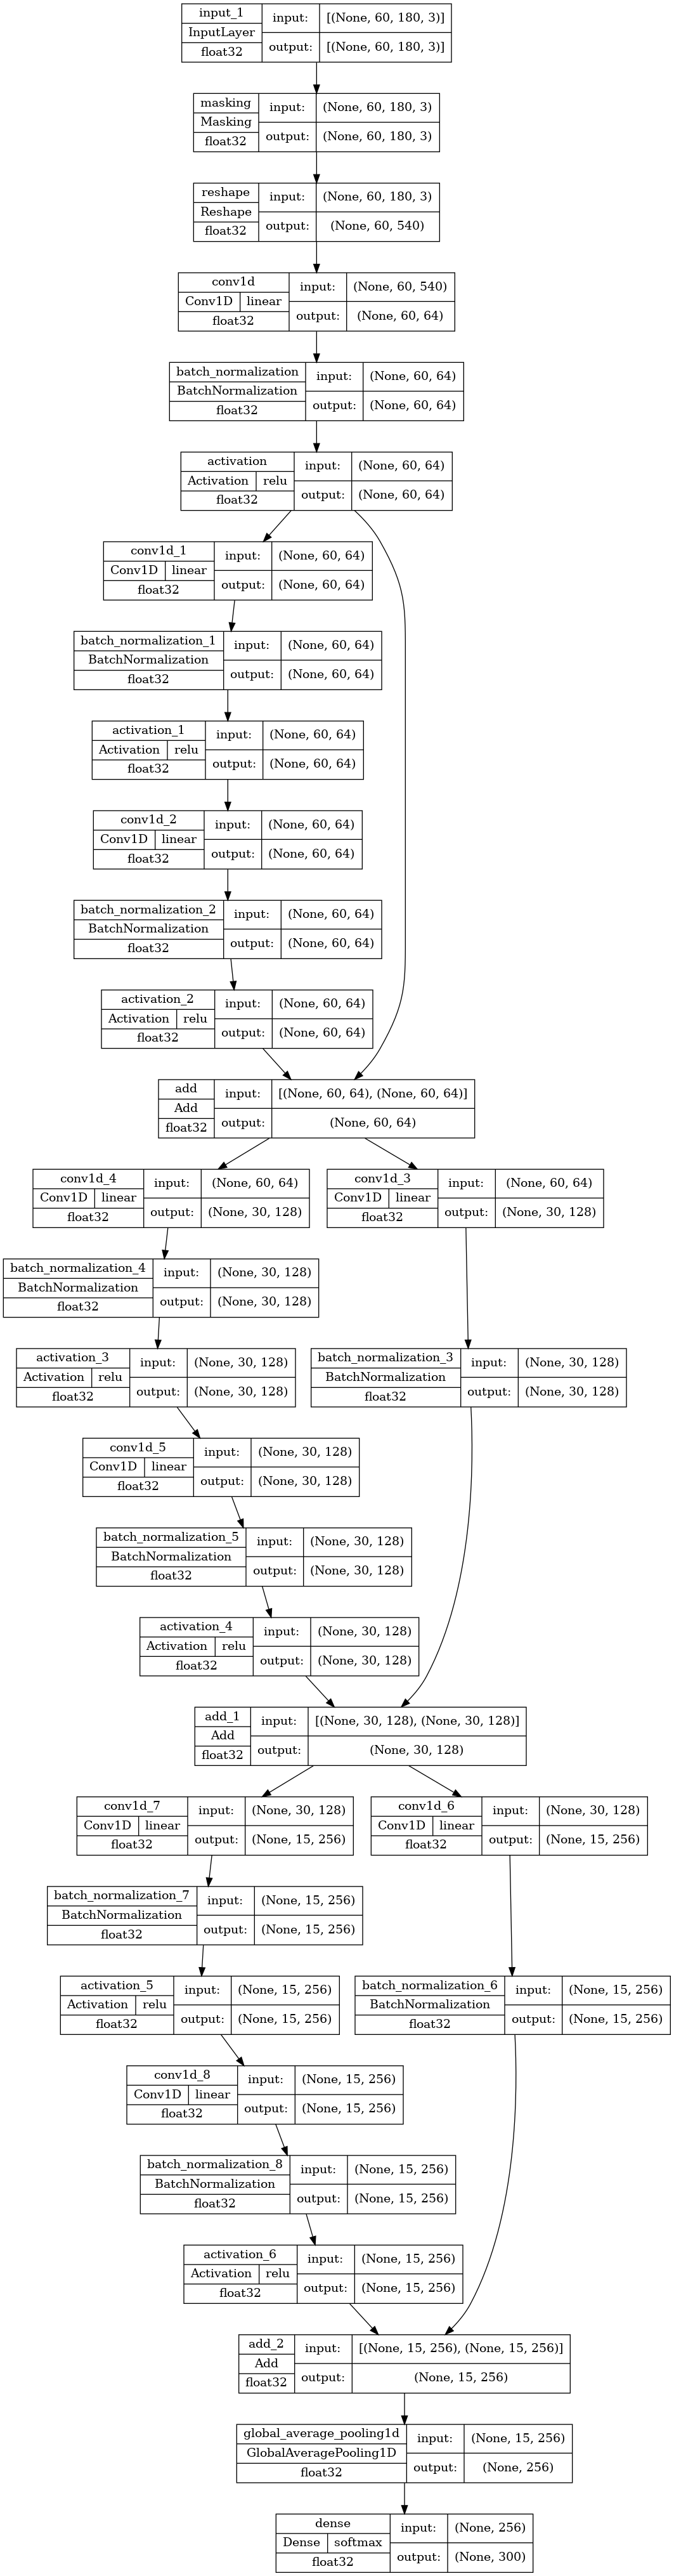

In [30]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, expand_nested=True, show_layer_activations=True)

### Compilação e treino do modelo

In [34]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=35,
    restore_best_weights=True)

lr_schedule = ExponentialDecay(
    0.001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = keras.optimizers.Adam(learning_rate =0.0001),
              metrics = ['accuracy'])

In [35]:
hist = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=200,
    batch_size=64,
    callbacks=[es]
)

: 

In [106]:
test_loss, test_accuracy = model.evaluate(X_test_seq, y_test_seq)

18/18 [==============================] - 0s 6ms/step - loss: 5.2678 - accuracy: 0.0951


In [29]:
test_loss2, test_accuracy2 = model.evaluate(X_test_seq, y_test_seq)

18/18 [==============================] - 0s 11ms/step - loss: 5.6536 - accuracy: 0.1389


### Learning Curve

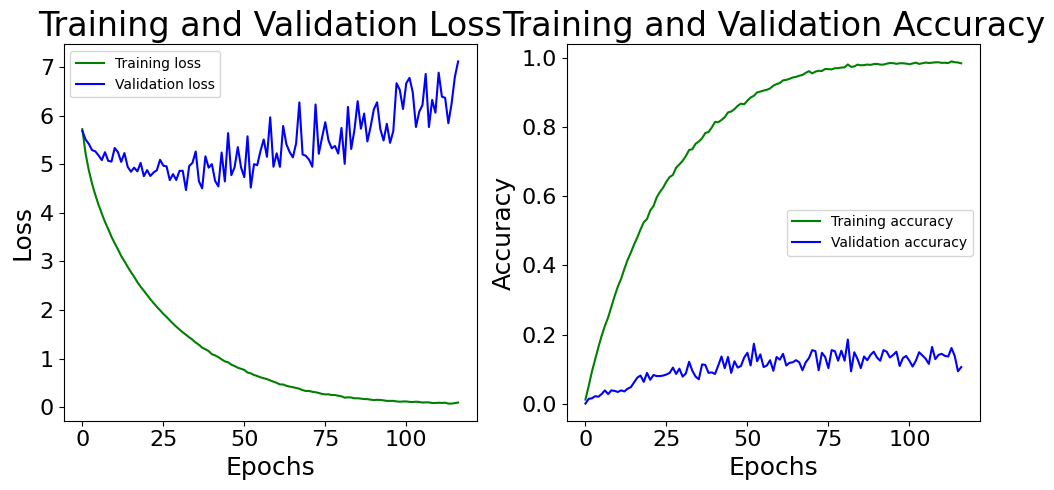

In [31]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

# Plotting loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, 'g', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, 'g', label='Training accuracy')
plt.plot(val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()